In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import random
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

In [8]:
import os
if os.getcwd().endswith('/notebooks'):
    os.chdir('..')

In [9]:
import sys
sys.path.append('.')

In [10]:
from classifyGenericRefactored import preprocess, classification_functions
from classifyGeneric import classifyOrg

In [11]:
dataset = pd.read_csv('../GenericClassifier_re_evaluation_2.txt', sep='\t', header=None,
                      names=['verified_label', 'label', '?', 'input'])
dataset['verified_label'] = dataset.verified_label.str.replace('VER_', '')

In [12]:
dataset.head()

,verified_label,label,?,input
0,SPE,SPE,1,(EMBL-EBI)
1,SPE,SPE,1,(GWC)2
2,SPE,SPE,1,‘Carol Davila’ University of Medicine and Phar...
3,GEN,SPE,1,20/20 Laboratory for Fuel Cells and Green Ener...
4,SPE,SPE,1,22 State University of New York at Albany


# Run the original classifier

In [13]:
dataset['predictions_orig'] = dataset.input.apply(classifyOrg)

In [14]:
score = lambda preds: precision_recall_fscore_support(dataset.verified_label, preds, labels=['GEN'])
# score = lambda preds: precision_recall_fscore_support(dataset.verified_label, preds, labels=['SPE'])

In [15]:
score(dataset.predictions_orig)

(array([0.79864061]), array([0.92519685]), array([0.85727314]), array([4064]))

# Run the refactored classifier

In [16]:
import classifyGenericRefactored
dataset['predictions_refac'] = dataset.input.apply(classifyGenericRefactored.classifyOrg)

In [17]:
score(dataset.predictions_refac)

(array([0.79864061]), array([0.92519685]), array([0.85727314]), array([4064]))

The refactored classifier returnes exactly the same scores.

# Ablation analysis

In [18]:
dataset.verified_label.value_counts()

GEN    4064
SPE    3659
Name: verified_label, dtype: int64

In [19]:
pred_func = lambda input: list(map(lambda f: f(*input), classification_functions))

In [20]:
dataset['preprocessed_input'] = dataset.input.apply(preprocess)
dataset['predictions'] = dataset.preprocessed_input.apply(pred_func)

In [21]:
first_not_null = lambda l: next((v for v in l if v is not None), 'None')
for i in range(len(classification_functions)):
    dataset['predictions_rule%02d' %i] = dataset.predictions.apply(lambda v: v[i] or 'None')
    dataset['predictions_rule0-%02d' %i] = dataset.predictions.apply(lambda v: first_not_null(v[:i+1]))
dataset['predictions_final'] = dataset.predictions.apply(first_not_null)

In [22]:
results = []
prediction_columns = sorted(c for c in dataset.columns if 'predictions_' in c)
for c in prediction_columns:
    predictions = dataset[c]
    num_preds = sum(1 for p in predictions if p != 'None')
    if num_preds > 0:
        p, r, f1, _ = score(predictions)
        print('Column: %s, predicted: %d, P=%f, R=%f, F1=%f' %(c, num_preds, p, r, f1))
    else:
        p = r = f1 = [0]
        print('Column: %s, predicted: 0' % c)
    results.append({
        'classifier': c.replace('predictions_', ''), 
        'prediction_count': num_preds, 'precision': p[0], 'recall': r[0], 'f1': f1[0]
    })

Column: predictions_final, predicted: 7723, P=0.798641, R=0.925197, F1=0.857273
Column: predictions_orig, predicted: 7723, P=0.798641, R=0.925197, F1=0.857273
Column: predictions_refac, predicted: 7723, P=0.798641, R=0.925197, F1=0.857273
Column: predictions_rule0-00, predicted: 3, P=1.000000, R=0.000738, F1=0.001475
Column: predictions_rule0-01, predicted: 9, P=0.888889, R=0.001969, F1=0.003928
Column: predictions_rule0-02, predicted: 1722, P=0.888889, R=0.001969, F1=0.003928
Column: predictions_rule0-03, predicted: 1807, P=0.888889, R=0.001969, F1=0.003928
Column: predictions_rule0-04, predicted: 1917, P=0.888889, R=0.001969, F1=0.003928
Column: predictions_rule0-05, predicted: 2210, P=0.888889, R=0.001969, F1=0.003928
Column: predictions_rule0-06, predicted: 2231, P=0.888889, R=0.001969, F1=0.003928
Column: predictions_rule0-07, predicted: 2231, P=0.888889, R=0.001969, F1=0.003928
Column: predictions_rule0-08, predicted: 2232, P=0.888889, R=0.001969, F1=0.003928
Column: predictions_

//anaconda2/envs/generic-classifier/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Column: predictions_rule05, predicted: 879, P=0.000000, R=0.000000, F1=0.000000
Column: predictions_rule06, predicted: 22, P=0.000000, R=0.000000, F1=0.000000
Column: predictions_rule07, predicted: 0
Column: predictions_rule08, predicted: 1, P=0.000000, R=0.000000, F1=0.000000
Column: predictions_rule09, predicted: 4, P=1.000000, R=0.000984, F1=0.001967
Column: predictions_rule10, predicted: 1054, P=0.000000, R=0.000000, F1=0.000000
Column: predictions_rule11, predicted: 13, P=0.000000, R=0.000000, F1=0.000000
Column: predictions_rule12, predicted: 574, P=0.975610, R=0.137795, F1=0.241483
Column: predictions_rule13, predicted: 2, P=1.000000, R=0.000492, F1=0.000984
Column: predictions_rule14, predicted: 955, P=0.997906, R=0.234498, F1=0.379757
Column: predictions_rule15, predicted: 270, P=0.985185, R=0.065453, F1=0.122750
Column: predictions_rule16, predicted: 0
Column: predictions_rule17, predicted: 1, P=1.000000, R=0.000246, F1=0.000492
Column: predictions_rule18, predicted: 119, P=1

In [23]:
# check the overlap of rules
(dataset[['predictions_rule%02d'%i for i in range(24)]] != 'None').sum(axis=1).describe()

count    7723.000000
mean        1.255859
std         1.181443
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max         6.000000
dtype: float64

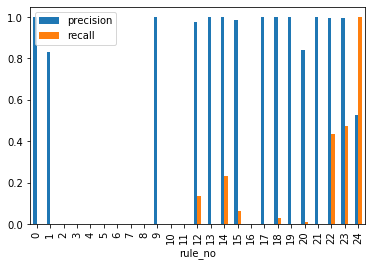

In [24]:
results = pd.DataFrame(results)
individual_results = results[results.classifier.str.contains(r'rule\d+$')].copy()
individual_results['rule_no'] = individual_results.classifier.str.replace('rule', '').astype(int)
individual_results['pct_predicted'] = individual_results.prediction_count / len(dataset)
_ = individual_results.plot.bar('rule_no', ['precision', 'recall'])

In [25]:
individual_results['function'] = individual_results.rule_no.apply(lambda i: classification_functions[i])
individual_results[['rule_no', 'function', 'precision', 'recall']]

,rule_no,function,precision,recall
28,0,<function cl_org_department1 at 0x12cbabea0>,1.000000,0.000738
29,1,<function cl_org_department2 at 0x12cbabd90>,0.833333,0.001230
30,2,<function cl_location at 0x12cbab510>,0.000000,0.000000
31,3,<function cl_cn at 0x12cbab048>,0.000000,0.000000
32,4,<function cl_company_types at 0x12cbab488>,0.000000,0.000000
33,5,<function cl_university at 0x12cbabe18>,0.000000,0.000000
34,6,<function cl_company at 0x12cbab620>,0.000000,0.000000
35,7,<function cl_whitelist at 0x12cbabc80>,0.000000,0.000000
36,8,<function cl_blacklist at 0x12cbabb70>,0.000000,0.000000
37,9,<function cl_department1 at 0x12cbabd08>,1.000000,0.000984


In [26]:
accumulated_results = results[results.classifier.str.startswith('rule0-')].copy()
accumulated_results['rule_no'] = accumulated_results.classifier.str.replace('rule0-', '').astype(int)
accumulated_results['pct_predicted'] = accumulated_results.prediction_count / len(dataset)

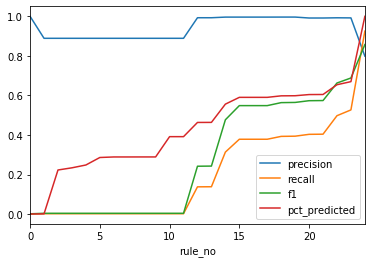

In [27]:
_ = accumulated_results.plot.line('rule_no', ['precision', 'recall', 'f1', 'pct_predicted'])

In [28]:
np.array(classification_functions)[[1,2]]

array([<function cl_org_department2 at 0x12cbabd90>,
       <function cl_location at 0x12cbab510>], dtype=object)

## Look at some examples

In [47]:
def print_func_examples(i):
    print('Function:', classification_functions[i].__name__)
    col = 'predictions_rule%02d' % i
    ds = dataset[dataset[col] != 'None'][['input', col]]
    if len(ds) > 0:
        print(ds.sample(min(10, len(ds))))
    else:
        print('No example found')

In [42]:
print_func_examples(3)

Function: cl_cn
                                   input predictions_rule03
1656                       CNRS URA 2052                SPE
1428        China Investment Corporation                SPE
5027                     IBM Corporation                SPE
1652                        CNRS UMR6232                SPE
1651                        CNRS UMR5220                SPE
5205                         INSERM U 80                SPE
4173       Ford Forschungszentrum Aachen                SPE
1649                       CNRS UMR 8622                SPE
4332           General Electric Research                SPE
1293  Cereal Research Non-profit Company                SPE


In [45]:
print_func_examples(16)

Function: cl_department7
No example found


In [48]:
print_func_examples(17)

Function: cl_department8
                                 input predictions_rule17
2883  Department of Studies in Physics                GEN


In [49]:
print_func_examples(18)

Function: cl_subj
                                      input predictions_rule18
3735                   Endocrine Laboratory                GEN
5888                      Internal Diseases                GEN
1797               Complex Systems Modeling                GEN
4329                      General Dentistry                GEN
5143              Infection Control Service                GEN
667                     Biomedical Research                GEN
3689  Electrical and Information Technology                GEN
6674     Laboratory of Bioorganic Chemistry                GEN
6670     Laboratory of Applied Hydrobiology                GEN
7364      Molecular Cardiovascular Research                GEN


# Correlate performance and input length

In [74]:
dataset['input_len'] = dataset.input.apply(len)

In [75]:
for pred_col in prediction_columns:
    score_col = pred_col.replace('predictions_', 'score_')
    dataset[score_col] = (dataset[pred_col] == dataset.verified_label).astype(int)

In [281]:
def performance_vs_input_len(classifier_name):
    pred_col = 'predictions_%s' % classifier_name
    def score_group_df(df): 
        num_preds = (df[pred_col] != 'None').sum()
#         true_gens = (df.verified_label == 'GEN').sum()
        p, r, f1, _ = precision_recall_fscore_support(df['verified_label'], df[pred_col], labels=['GEN'])
        return pd.Series({
            'precision': p[0],
            'recall': r[0],
            'f1': f1[0],
            'pct_predicted': num_preds / float(len(df)),
#             'pct_true_gen': true_gens / float(len(df))
        })
    return dataset.groupby('input_len').apply(score_group_df).reset_index()

def plot_performance_vs_input_len(classifier_name):
    results = performance_vs_input_len(classifier_name)
    ax = results.plot.line('input_len', ['precision', 'recall', 'pct_predicted'])
    ax.axhline(0.95, ls='--', label='Goal: 95%')

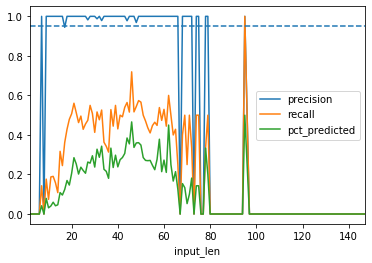

In [282]:
plot_performance_vs_input_len('rule22')

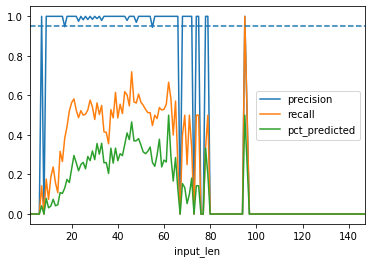

In [283]:
plot_performance_vs_input_len('rule23')

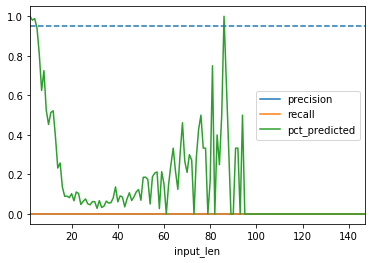

In [284]:
plot_performance_vs_input_len('rule10')

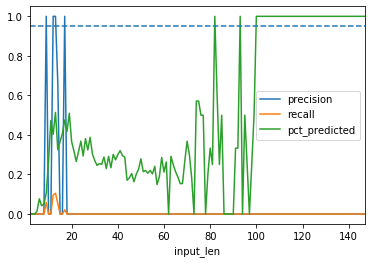

In [285]:
plot_performance_vs_input_len('rule0-06')

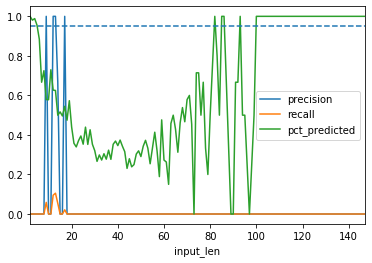

In [286]:
plot_performance_vs_input_len('rule0-10')

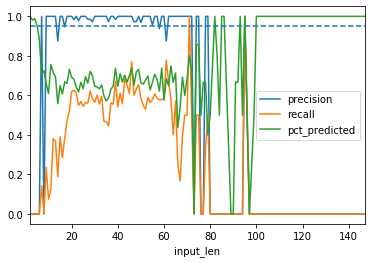

In [287]:
plot_performance_vs_input_len('rule0-23')

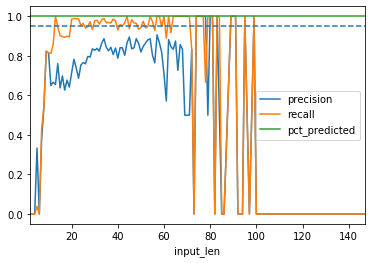

In [288]:
plot_performance_vs_input_len('rule0-24')

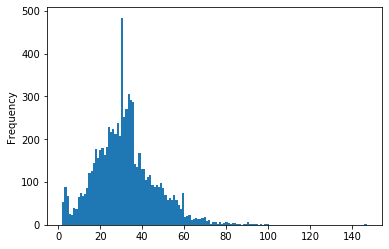

In [172]:
_ = dataset.input_len.plot.hist(bins=140)

# Look at the shorter strings

In [203]:
ds_short_input = dataset[dataset.input_len < 15]
ds_short_input[['input', 'verified_label']].sample(10)

,input,verified_label
942,"CEA, Saclay",SPE
1344,Chem. Dept.,GEN
324,AP Agric.Univ.,SPE
4605,H. de La Paz,GEN
3741,ENEA,SPE
3248,DHOS,GEN
4828,hôpital Civil,GEN
3346,Div. Hematol.,GEN
6985,Mar. Sci. Lab.,GEN
936,CDC,GEN


In [206]:
len(ds_short_input)

699

In [205]:
(ds_short_input['predictions_rule10'] != 'None').sum()

437

In [204]:
precision_recall_fscore_support(ds_short_input['verified_label'], ds_short_input['predictions_rule10'], labels=['GEN'])

(array([0.]), array([0.]), array([0.]), array([297]))

In [178]:
dataset[dataset.input_len < 15].verified_label.value_counts()

SPE    402
GEN    297
Name: verified_label, dtype: int64

In [184]:
297/len(dataset)

0.0384565583322543